In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json('files/data.json')

In [3]:
df.shape

(14337, 44)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14337 entries, 0 to 14336
Data columns (total 44 columns):
acct_type             14337 non-null object
approx_payout_date    14337 non-null int64
body_length           14337 non-null int64
channels              14337 non-null int64
country               14256 non-null object
currency              14337 non-null object
delivery_method       14321 non-null float64
description           14337 non-null object
email_domain          14337 non-null object
event_created         14337 non-null int64
event_end             14337 non-null int64
event_published       14238 non-null float64
event_start           14337 non-null int64
fb_published          14337 non-null int64
gts                   14337 non-null float64
has_analytics         14337 non-null int64
has_header            8928 non-null float64
has_logo              14337 non-null int64
listed                14337 non-null object
name                  14337 non-null object
name_length      

In [6]:
df['USD'] = (df['currency'] == 'USD').astype(int)
df['USD'].value_counts()

1    9696
0    4641
Name: USD, dtype: int64

In [34]:
df['ticket_types'].iloc[0]

[{u'availability': 1,
  u'cost': 25.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 800},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 100},
 {u'availability': 1,
  u'cost': 550.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 20}]

In [7]:
df['fraud'] = df['acct_type'].isin(['fraudster_event','fraudster','fraudster_att']).astype(int)
df['fraud'].value_counts()

0    13044
1     1293
Name: fraud, dtype: int64

In [16]:
pd.crosstab(df['fraud'],df['delivery_method'])

delivery_method,0.0,1.0,3.0
fraud,,,
0,7319,5481,240
1,1201,73,7


In [15]:
df['delivery_method'].value_counts()

0.0    8520
1.0    5554
3.0     247
Name: delivery_method, dtype: int64

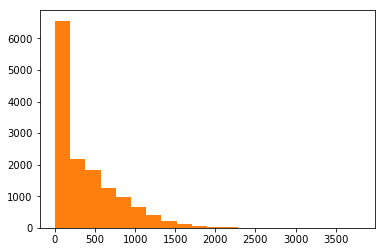

In [12]:
import matplotlib.pyplot as plt
plt.hist(df.user_age,bins=20)
plt.show()

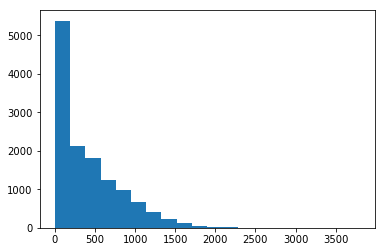

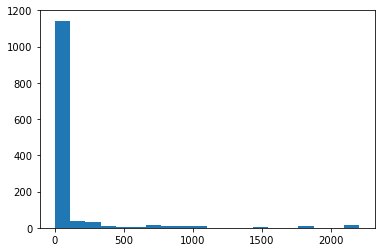

In [14]:
plt.hist(df.user_age[df['fraud']==0],bins=20)
plt.show()
plt.hist(df.user_age[df['fraud']==1],bins=20)
plt.show()

In [85]:
df.channels.value_counts()

8     3364
0     2941
5     2459
11    2312
6     1736
4      556
12     470
10     237
13     232
9       20
7       10
Name: channels, dtype: int64

In [86]:
pd.crosstab(df.channels,df.fraud)

fraud,0,1
channels,,
0,2375,566
4,531,25
5,2229,230
6,1574,162
7,8,2
8,3255,109
9,19,1
10,229,8
11,2169,143


In [84]:
df.payout_type.value_counts()

ACH      10666
CHECK     3178
           493
Name: payout_type, dtype: int64

### NLP model

In [17]:
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
tokenizer = RegexpTokenizer('\w+')
stemmer = SnowballStemmer('english')

stop_words = set(stopwords.words('english'))


def vectorize_descriptions(des):
    soup = BeautifulSoup(des, 'html.parser')
    text = ' '.join([p.text for p in soup.findAll('p')])
    words = tokenizer.tokenize(text)
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [26]:
df['clean_description'] = df['description'].apply(vectorize_descriptions)
df['clean_description'].head()

0    Party Starz Entertaintment Diverse Internation...
1    Join us quick one night community building tri...
2    Fees The cost training 100 00 per person It im...
3    Affiliations due respect 2013 Calendar Year It...
4    Writers filmmakers need understand legal right...
Name: clean_description, dtype: object

In [27]:
vectorizer = TfidfVectorizer(max_features=5000)
vecs = vectorizer.fit_transform(df['clean_description'])

In [28]:
features = vecs.toarray()

In [29]:
y = df['fraud'].values
X = features
from sklearn.metrics import f1_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

f1 = make_scorer(f1_score)
nb = MultinomialNB()
scores = cross_val_score(nb,X,y,scoring=f1)
print np.mean(scores)

0.0615982243887


In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
scores = cross_val_score(rf,X,y,scoring=f1)
print np.mean(scores)

0.233613060477
